Adrià Melús - 1527144

# Pràctica 3 d'APC

## 1.Introducció

Elon Musk és considerada la persona amb més diners del planeta actualment; és el director executiu de la empresa aerospacial SpaceX i de la d'automòvils elèctrics Tesla, i fa poc va rebre el títol de la persona del any per part de la revista Time. 

Elon Musk també és algú que destaca per la seva activitat a Twitter, on publica memes o frases que deixen a tot el món pensant si realment les diu en serio. Mai està massa ocupat per comentar alguna broma o un pensament espontani. Tot i això, els seus intents per semblar graciós, per lo general acaben mosrant la seva irresponsabilitat al publicar tantes afirmacions confuses, insensibles o incorrectes.

En honor al seu nou títol, que segons la publicació és otorgat a "la persona o persones que més han afectat les notícies i les nostres vides, cap a bé o cap a malament".

Aquest és l'informe de  l'anàlisi de resultats en aprenentatge computacional d'una base de dades de kaggle que conté més de 25.000 tweets d'Elon Musk: https://www.kaggle.com/taruntiwarihp/elon-musk-tweets

El propòsit principal d'aquest anàlisi és el de predir el sentiment d'un tweet segons sigui positiu o negatiu:

<img src="../figures/positive-negative.jpg">

Following topics would be covered as an outline for this article:

Data cleaning and preparation.
Analysis of the data.
Analysis and preprocessing text with NLTK.
Resampling data.
Model creation to predict sentiment.


### LLibreries

Per aquest projecte haurem de instalar les seguents llibreries:

Matplotlib, seaborn i wordcloud per la visualització gràfica de dades.

Pandas i numpy pel tractament d'informació.

SkLearn per l'entrenament dels nostres models.

NLTK pel processament de text.

imblearn pel "resampling" de la informació.

In [52]:
# Import 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import scikitplot as skplt
import plotly.graph_objs as go
import nltk

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud, STOPWORDS
from prettytable import PrettyTable
from plotly.offline import iplot

from imblearn.combine import SMOTETomek

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

nltk.download('stopwords', quiet=True);
nltk.download('vader_lexicon', quiet=True);

## 2. Informació de les dades

Primer de tot observarem detalladament les dades i les entendrem. A continuació, si és necessari, netejarem el dataset i el prepararem per analitzar-lo.

In [53]:
# Carregar el Dataset

dataset = "../dataset/Elon Musk.csv"
dades = pd.read_csv(dataset)

# Eliminem la primera columna perquè es tracta d'un index que no ens fa falta
dades.drop(dades.columns[0], inplace = True, axis = 1)
dades.head(1)


,tweets,sentiment
0,@elonmusk @realfuckingnews @business Ancient crypto? That's math... When I first learned what was a blockchain I wa… https://t.co/YepHdu4OEv,pos


In [54]:
# Quantes files i columnes hi ha al dataset? Cada fila representa un tweet
print("Hi ha {} columnes".format(dades.shape[1]), "i {} files.".format(dades.shape[0]))
print(dades.dtypes)

Hi ha 2 columnes i 25757 files.
tweets       object
sentiment    object
dtype: object


Com es pot observar, aquest dataset conté 25757 files i 2 columnes. Cada fila correspon a un tweet i inclou dues variables:

tweets: Variable de tipus object amb el contingut d'un tweet que esmenta @elonmusk.
sentiment: Variable de tipus object que indica el sentiment del tweet. L'atribut sentiment pot prendre dos valors: pos (positiu) o neg (negatiu)

Comprovem si hi ha cap valor nul:

In [55]:
null_counts = dades.isnull().sum()
null_counts[null_counts>0]

Series([], dtype: int64)

No s'ha trobat cap valor null o Nan, per tant no farà falta eliminar cap fila, de moment.

## 3. Anàlisi de la informació

In [56]:
dades.describe(exclude=[np.number]).drop("count")

,tweets,sentiment
unique,25418,2
top,@Twitter @elonmusk,pos
freq,67,22725


Hem vist que el dataset té tan sols dues variables rellevants on una és categòrica. Com es pot observar, hi ha 25.418 tweets únics i dos valors únics (pos i neg) de la variable sentiment.

Ara anem a visualitzar gràficament la distribució de la variable objectiu sentiment 

In [57]:
# Funció per la visualització en un gràfic de barres per la distribució de l'atribut x que es pasa com a paràmetre 
def plot_distributionCount(x, data):
    plt.subplots(figsize=(6, 4))
    sns.countplot(x=x, data=data, order=data[x].value_counts().index, palette='icefire_r')
    plt.xlabel('sentiment')
    plt.tight_layout()
    plt.show()

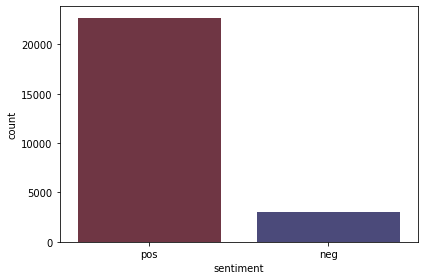

In [58]:
plot_distributionCount('sentiment',dades)

Com es pot observar, l'atribut sentiment prèn el valor positiu (88%) amb molta més freqüència que el negatiu (12%).

### 3.1. Anàlisi i neteja de tweets

Una vegada hem analitzat la informació i les variables de les que disposem, començarem a analitzar el text dels tweets. El tractament de tweets és important per tal de que posteriorment el text encaixi amb un model d'aprenentatge computacional  correctament.  

In [59]:
pd.set_option('max_colwidth', 700)
dades[['tweets', 'sentiment']].sample(5)

,tweets,sentiment
6674,@KarakoseDorahan @elonmusk @NASA Why turkey going to moon when everyone else is aiming for Mars?,pos
3863,Tamam tamam aslında marsta yaşayan varlıklardık sonra dünyaya geldik marsı yaşanmaz hale getirip. @NASA @elonmusk @NASAdata,pos
7059,"@elonmusk @NASA Now it's Your turn, you have the resources, the man power, and doing it would just piss off SO many people",neg
20634,@elonmusk @business @michael_saylor @tyler @cameron @APompliano @jack This Elon guy is not the Droid you’re looking for.,pos
9119,RT @BitcoinBrains: Makes a lot more sense than pieces of paper with pictures of ancient psychopaths on them.,pos


Natural Language Toolkit (NLTK) és un conjunt de biblioteques i programes que ajuden al processament del llenguatge natural. Utilitzarem les eines que proporciona NLTK per "netejar" els tweets, és a dir, dividir-los en paraules i controlar la puntuació, els números, les @ o les paraules buides.

La següent funció converteix el tweet que es passa com a paràmetre en un text en minúscula, esborrra els numeros i puntuacions i separa el text en diferents paraules. L'idioma dels tweets és l'anglès, i un dels passos de la funció és eliminar les anomenades "stop words" d'aquest idioma. Les stop words son paraules freqüentment utilitzades (com preposicions) però que no aporten significat al tweet i per tant no són rellevants en aquest cas.

In [60]:
# Converteix el tweet a un text net
def preProcessing(tweet):
    text = tweet.lower()
    
    # treure puntuacio
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # treure números
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    text = RegexpTokenizer(r'\w+').tokenize(str(text))
    
    # treure stop words
    text = [x for x in text if x not in stopwords.words('english')]
    
    # treure paraules buides
    text = [t for t in text if len(t) > 0]
    
    # unó de tot
    tweetNet = " ".join(text)
    return(tweetNet)

In [84]:
# Converteix el tweet a un text net sense @
def preProcessingTweet(tweet):
    text = tweet.lower()
    
    # treure puntuacio
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # treure números
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    #treure @
    text = [word for word in text if not any ("@" == c for c in word)]

    text = RegexpTokenizer(r'\w+').tokenize(str(text))
    
    # treure stop words
    text = [x for x in text if x not in stopwords.words('english')]

    #treure elonmusk
    text = [x for x in text if x != "elonmusk"]

    
    # treure paraules buides
    text = [t for t in text if len(t) > 0]
    
    # unó de tot
    tweetNet = " ".join(text)
    return(tweetNet)

In [85]:
## HACER VARIAS PRUEBAS REMOVIENTDO X O Y

In [86]:
dades['tweetsNets'] = dades['tweets'].apply(lambda x: preProcessing(x))

In [87]:
pd.set_option('max_colwidth', 900)
dades.sample(8)

,tweets,sentiment,tweetsNets
21591,"@Spinance @elonmusk @business Well, all the VIPs that held BNB became that much wealthier, not an issue for them. H… https://t.co/Bcy3VSz6ty",pos,spinance elonmusk business well vips held bnb became much wealthier issue h
19721,@MadDogecoins @elonmusk @business I think batteries are of most value to Texans right not. And of course the help t… https://t.co/sKUCQjtRBf,pos,maddogecoins elonmusk business think batteries value texans right course help https co skucqjtrbf
14515,@HamariJaan @WarrenBuffett @elonmusk Buffet is old asf he has no idea what crypto is,neg,hamarijaan warrenbuffett elonmusk buffet old asf idea crypto
25611,💥Atttention @elonmusk some MF are using your name to scam right now big time. Do something or say something to save… https://t.co/QidJUmjs68,neg,atttention elonmusk mf using name scam right big time something say something save
3020,@10_dolla @muneeb @elonmusk @realfuckingnews @business There aren't enough towels in the world to stop the sewage flowing from his mouth.,neg,muneeb elonmusk realfuckingnews business enough towels world stop sewage flowing mouth
5029,@Tucornine @NAYANBI99431277 @elonmusk @NASA Also CureVac.,pos,tucornine elonmusk nasa also curevac
15373,@Sofiaan @WarrenBuffett @Tesla @elonmusk @Chevron @Gfilche @HyperChangeTV complete BS. If Tesla investors cared abo… https://t.co/quiTMTI8TH,pos,sofiaan warrenbuffett tesla elonmusk chevron gfilche hyperchangetv complete bs tesla investors cared abo
18008,@AlanEggleston @NASAPersevere @elonmusk It's a beautifully designed EC. It'd be interesting to see what the Tesla M… https://t.co/l1v9S3xTGk,pos,alaneggleston nasapersevere elonmusk beautifully designed ec interesting see tesla


In [ ]:
dades['tweetsNets'] = dades['tweets'].apply(lambda x: preProcessingTweet(x))

In [ ]:
pd.set_option('max_colwidth', 900)
dades.sample(8)

Una vegada hem afegit una nova columna amb els tweets nets, 

### WordCloud per paraules positives o negatives

## Mètode d'aprenentatge computacional aplicat,

## Resultats

## 6. Conclusions


In [ ]:
## Conclusions